PDB | https://rcsb.org

## 구조 데이터(structure data)란?

- 분자의 구조를 나타내는 파일 형식
- pdb, sdf, mol2, mmcif 등등 다양한 포맷이 존재
- 포맷마다 양식이 조금씩 다르지만 핵심은 원자마다 x, y, z 좌표 형태로 나타내는 것
- 단백질의 구조는 매우 복잡 --> 주로 pdb (legacy) 파일이나 mmcif (fancy) 파일로 저장됨

## 단백질 구조 파일 (PDBx/mmCIF) 이해하기
왜 PDXc/mmcif 인가?
- legacy pdb 포맷은 저장할 수 있는 원자의 갯수 제한이 있음(고정 열 기반) -> 이와 상관없이 활용되는 mmcif 포맷이 권장됨
- 최근 deposit되는 구조들의 경우에는 mmcif로만 제공되는 경우도 있음.

분석하고 싶은 단백질을 골라서 mmcif 파일로 다운로드한 뒤 현재 디렉토리에 위치시키고 살펴봅시다.

규칙
- 항상 data_ 로 시작하여 그 뒤에는 데이터 블록이 위치
- \# 으로 시작하는 줄은 주석 -> 기계가 읽지 않음
- 기록할 데이터 항목을 키-밸류 쌍으로 표현함

    `_category.item_name  value`
- 반복되는 데이터를 표현하고자 하는 경우 이들을 루프로 묶어서 반복 표현
    ```
    data_4HHB
    #
    _entry.id   4HHB
    _audit.creation_date 1984-07-28
    _audit.update_record 'Initial release'
    #
    loop_
    _audit_author.name
    _audit_author.pdbx_ordinal
    'G.FERMI' 1
    'M.F.PERUTZ' 2
    #
    _citation.id primary
    _citation.title 
    ;"THE CRYSTAL STRUCTURE OF HUMAN DEOXYHAEMOGLOBIN AT 1.74 
    ANGSTROMS RESOLUTION"
    ;
    ```

    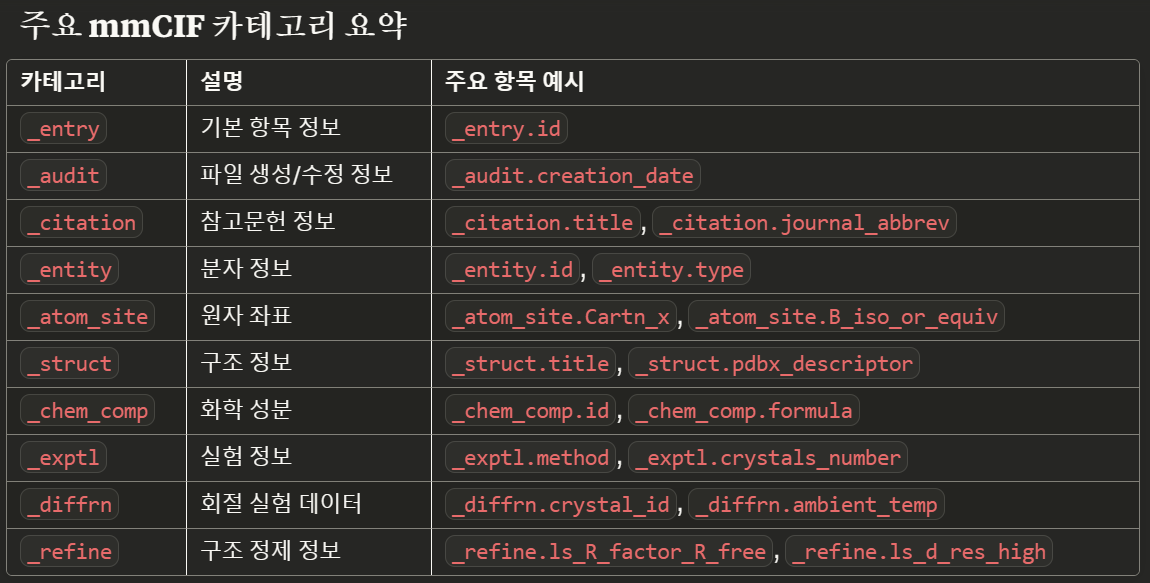

## RCSB API를 이용해서 데이터 검색 및 다운로드
- 크게 원하는 조건의 데이터 엔트리를 검색하는 search API와, 특정 엔트리에 대한 정보를 가져오는 data API로 구분


mmcif 파일 구성

- 보통 하나의 data container == pdb entry
- data category: 같은 대상에 대한 데이터 아이템을 그룹화 (_atom_site 등)
- data item: 데이터 카테고리 내의 개별 필드 -> 하나의 값을 가짐


In [1]:
# wwPDB 에서 가장 우선으로 활용되는 mmcif parser

from mmcif.io.IoAdapterCore import IoAdapterCore

io = IoAdapterCore()

list_data_container = io.readFile("4hhb.cif")

data_container = list_data_container[0]

entity = data_container.getObj("entity")

In [14]:
atom_site = data_container.getObj("atom_site").data

In [17]:
atom_site[0]

['ATOM',
 '1',
 'N',
 'N',
 '.',
 'VAL',
 'A',
 '1',
 '1',
 '?',
 '19.323',
 '29.727',
 '42.781',
 '1.00',
 '49.05',
 '?',
 '1',
 'VAL',
 'A',
 'N',
 '1']